In [1]:
import numpy as np
import matplotlib.pyplot as plt
from euler_cromer import simulate
from utils.colorline import colorline

In [2]:
rho = 1.2  # luftens densitet
g = 9.82  # gravitation

class ThrowObject():
    def __init__(self, m, C_d, A):
        self.m = m
        self.C_d = C_d
        self.A = A
        self.k_d = 0.5 * C_d * rho * A

    def set_initial(self, y0, v0, alpha=None):
        # Specifiera antingen (y0, fart, vinkel) eller vektorer (y0, v0)
        if alpha and isinstance(v0, (float, int)):
            self.v0 = np.array([v0 * np.cos(alpha), v0 * np.sin(alpha)])
        elif (hasattr(y0, '__iter__') and hasattr(v0, '__iter__')):
            self.v0 = v0
        else: raise ValueError()
        self.y0 = y0
        self.initial = [self.y0, self.v0]

    # Ger objektets acceleration vid kast med luftmotstånd
    def f_drag(self, y, v, t):
        Fd = -v * self.k_d * np.linalg.norm(v) # riktning: -v, magnitud: k_d*|v|^2
        Fg = np.array([0, -self.m * g]) # gravitationskraft
        return (Fd + Fg) / self.m
    # utan luftmotstånd, a(y) = -g, a(x) = 0
    def f_no_drag(self, y, v, t):
        return np.array([0, -g])

class Sphere(ThrowObject):
    def __init__(self, r, m, C_d=0.47):
        super().__init__(m, C_d, A=np.pi*r**2)

### Jämför med och utan luftmotstånd

Luftmotstånd
maxhöjd: 14.736m efter 1.540s
tid till y=0: 3.430s
maxfart: 40.000m/s efter 0.000s
sista fart: 23.474m/s




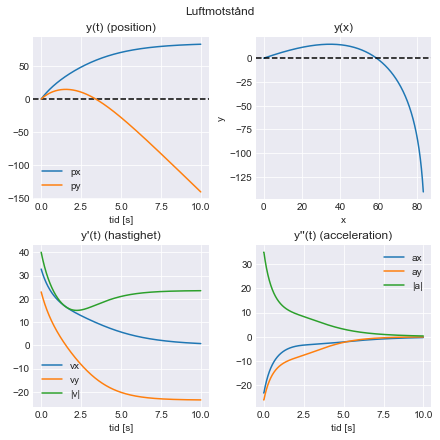

Text(0, 0.5, 'fart [m/s]')

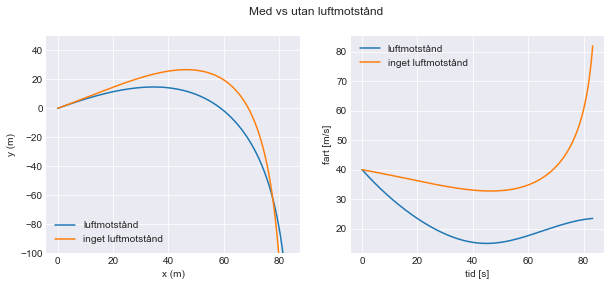

In [10]:
ball = Sphere(0.1, 0.5)
ball.set_initial(y0=[0, 0], v0=40, alpha=np.radians(35))
dt, to_time = 0.01, 10

drag = simulate(ball.f_drag, ball.initial, dt=dt, to_time=to_time, plot=True, title="Luftmotstånd")
no_drag = simulate(ball.f_no_drag, ball.initial, dt=dt, to_time=to_time, plot=False)

fig, axs = plt.subplot_mosaic('ab', figsize=(10, 4))
fig.suptitle("Med vs utan luftmotstånd")
axs['a'].plot(drag['x'], np.column_stack((drag['y'], no_drag['y'])), label=['luftmotstånd', 'inget luftmotstånd'])
axs['a'].legend()
axs['a'].set_ylim([-100, 50])
axs['a'].set_xlabel('x (m)'); axs['a'].set_ylabel('y (m)')
axs['b'].plot(drag['x'], np.column_stack((drag['speed'], no_drag['speed'])), label=['luftmotstånd', 'inget luftmotstånd'])
axs['b'].legend()
axs['b'].set_xlabel('tid [s]'); axs['b'].set_ylabel('fart [m/s]')

### Testa bollar med olika radier

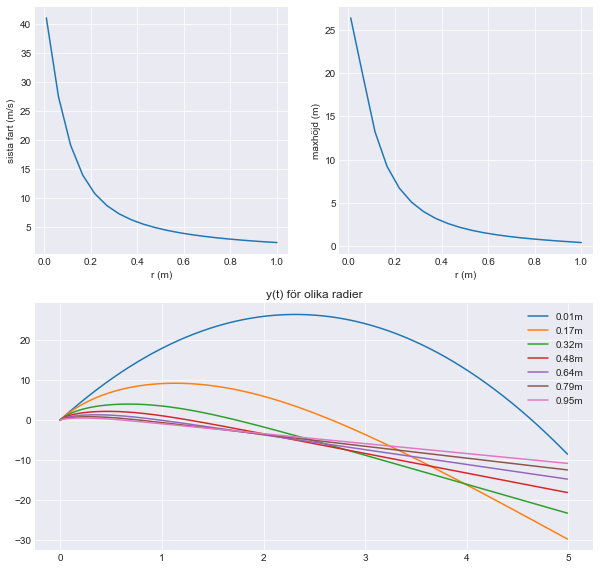

In [31]:
rs = np.linspace(0.01, 1, 20)
top_speeds, max_heights, ys = [], [], []
for r in rs:
    sphere = Sphere(r=r, m=0.5)
    sphere.set_initial(y0=[0, 0], v0=40, alpha=np.radians(35))
    res = simulate(sphere.f_drag, sphere.initial, dt=0.01, to_time=5, plot=False)
    top_speeds.append(np.linalg.norm(res['y_prime'], axis=1)[-1])
    max_heights.append(res['y'].max())
    ys.append(res['y'])
    time = res['t']

fig, axs = plt.subplot_mosaic('ab\ncc', figsize=(10, 10))
axs['a'].plot(rs, top_speeds)
axs['a'].set_ylabel('sista fart (m/s)')
axs['a'].set_xlabel('r (m)')

axs['b'].plot(rs, max_heights)
axs['b'].set_ylabel('maxhöjd (m)')
axs['b'].set_xlabel('r (m)')

axs['c'].plot(time, np.array(ys[::3]).T, label=list(map(lambda r: f'{r:.2f}m', rs[::3])))
axs['c'].legend()
axs['c'].set_title('y(t) för olika radier')

plt.show()

### Jämför olika värden på tidssteget dt

### Jämför med exakt lösning

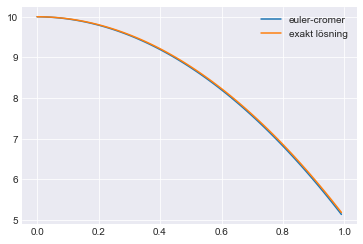

In [29]:
def freefall_solution(t, thing):
    # analytisk lösning y(t) från https://en.wikipedia.org/wiki/Free_fall
    y0, m, A, C_d = thing.y0, thing.m, thing.A, thing.C_d

    vel_terminal = np.sqrt((2*m*g) / (rho*C_d*A))
    y = y0[1] - (vel_terminal**2 / g) * np.log(np.cosh((g*t)/vel_terminal))
    return y

ball = Sphere(0.01, 0.5)
ball.set_initial(y0=[0, 10], v0=[0, 0]) # släpp från 10m

res = simulate(ball.f_drag, ball.initial, dt=0.01, to_time=1, plot=False)
y_true = freefall_solution(res['t'], ball)
plt.plot(res['t'], res['y'], label='euler-cromer')
plt.plot(res['t'], y_true, label="exakt lösning")
plt.legend()
plt.show()